# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [1]:
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

#compute cluster
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

#dataset
from azureml.core import Dataset
from sklearn.model_selection import train_test_split

#automl
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails

#model deployment
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice

# Others
import logging
import os
import csv

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [2]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

# choose a name for experiment
experiment_name = 'my-capstone'
experiment=Experiment(ws, experiment_name)

quick-starts-ws-138673
aml-quickstarts-138673
southcentralus
d4ad7261-832d-46b2-b093-22156001df5b


Check the experiment

In [3]:
experiment

Name,Workspace,Report Page,Docs Page
my-capstone,quick-starts-ws-138673,Link to Azure Machine Learning studio,Link to Documentation


### Computer Cluster

Lets create computer cluster first, if we have any existing cluster we will use that one, otherwise we will create a brand new cluster

here, we will use **max_nodes** 6

In [4]:
# Choosing a name for the CPU cluster
amlcompute_cluster_name = "my-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',# for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 3)

Creating
Succeeded................................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


### Create Datasets

IN this project we are going to use **The Heart Failure Dataset** and this datasets can be found in [Kaggle](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data). 

The Heart failure dataset has total 13 columns 
- age
- anaemia
- creatinine_phosphokinase 
- diabetes
- ejection_fraction
- high_blood_pressure
- platelets
- serum_creatinine
- serum_sodium
- sex
- smoking
- time
- DEATH_EVENT.

First, we will create the datasets and then we will register that dataset into the workspace

In [6]:
from azureml.data.dataset_factory import TabularDatasetFactory

url = "https://raw.githubusercontent.com/Iamsdt/Udacity-ML-Azure-Capstone/master/datasets/heart_failure_clinical_records_dataset.csv"

dataset = Dataset.Tabular.from_delimited_files(url)        

#Register Dataset in Workspace
key = "Bank-marketing"
description_text = "Bank Marketing DataSet for Udacity Course 2"
dataset = dataset.register(workspace=ws, name=key, description=description_text)

# convert into pandas
df = dataset.to_pandas_dataframe()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
age                         299 non-null float64
anaemia                     299 non-null int64
creatinine_phosphokinase    299 non-null int64
diabetes                    299 non-null int64
ejection_fraction           299 non-null int64
high_blood_pressure         299 non-null int64
platelets                   299 non-null float64
serum_creatinine            299 non-null float64
serum_sodium                299 non-null int64
sex                         299 non-null int64
smoking                     299 non-null int64
time                        299 non-null int64
DEATH_EVENT                 299 non-null int64
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [8]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [9]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### Lets explore Data

In [14]:
# !pip install seaborn

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


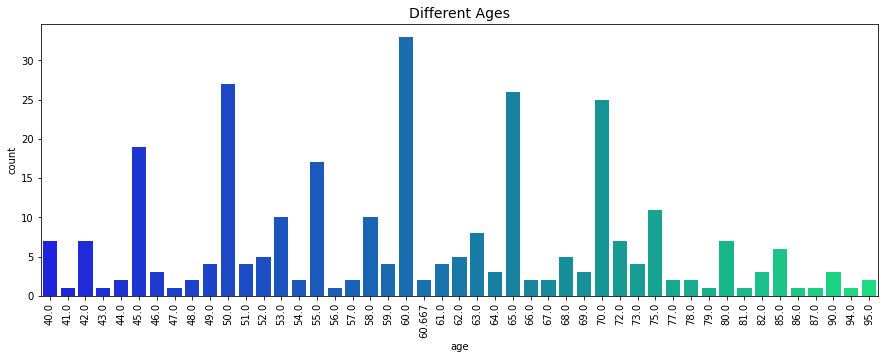

In [17]:
import seaborn as sns

plt.figure(figsize=(15,5))
sns.countplot(df.age,palette='winter')
plt.title('Different Ages',fontsize=14)
plt.xticks(rotation=90)
plt.show()

Check Correlation

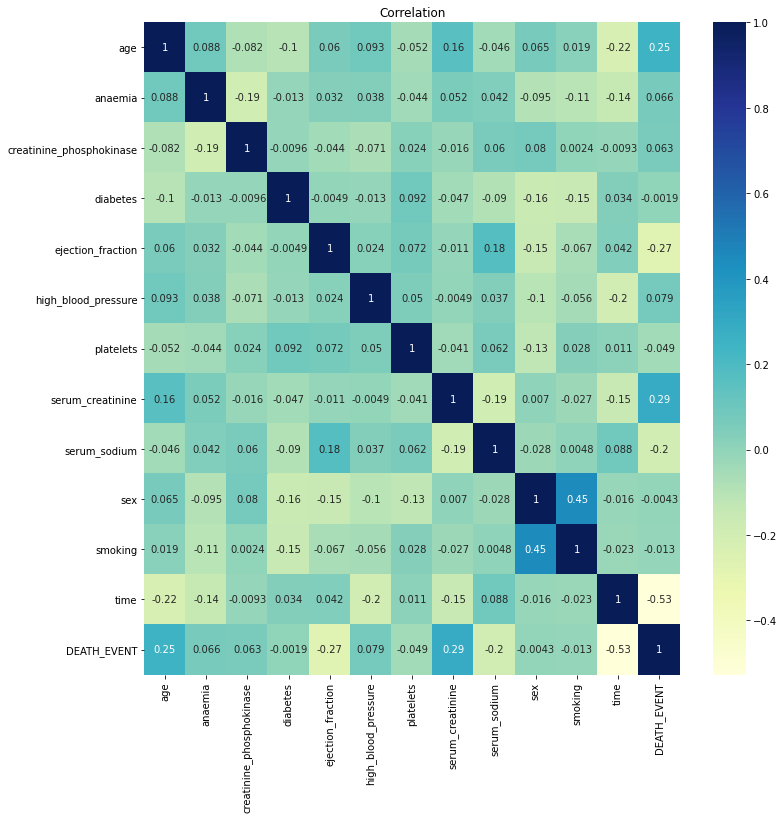

In [19]:
records_corr = df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(records_corr, annot=True, cmap="YlGnBu")
plt.title('Correlation')
plt.show()

check relationship between **Age**, **Diabetes** VS **Death Event**

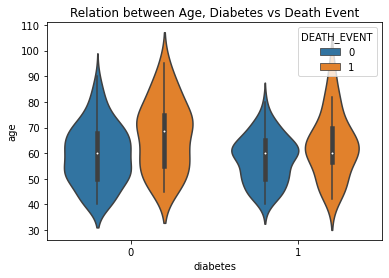

In [20]:
ax = sns.violinplot(x='diabetes', y='age', data = df, hue = 'DEATH_EVENT')
plt.title('Relation between Age, Diabetes vs Death Event')
plt.show()

Let's allow AutoML to figure out

## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In **AutoML**, I used following parameters



| No.  | Title                       | Value          |
| ---- | --------------------------- | -------------- |
| 1.   | Task                        | Classification |
| 2.   | Primary Metric              | Accuracy       |
| 3.   | Number of cross validations | 5              |
| 4.   | Experiment Time out minutes | 20             |

Explanation:
- **task** -> **classificaion**, we want to determine value of DEATH_EVENT based on the other 12 features
- **primary_metric** -> **accuracy**, we choose accuracy as our primary metrics
- **max_concurrent_iterations** -> **5**, in our cluster, we have maximum 6 nodes, so we can use 5

In [24]:
# automl settings
automl_settings = {
    "n_cross_validations": 5,
    "primary_metric": 'accuracy',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 5,
}

# folder location
project_folder = './heart-failure'

# automl config
automl_config = AutoMLConfig(task = 'classification',
                            experiment_timeout_minutes=20,
                            compute_target = compute_target,
                            training_data = dataset,
                            label_column_name = 'DEATH_EVENT',
                            featurization= 'auto',
                            path = project_folder,
                            debug_log = "automl_errors.log",
                            **automl_settings)

In [25]:
# TODO: Submit your experiment
remote_run = experiment.submit(automl_config)

Running on remote.


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [39]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [ ]:
# Lets wait
remote_run.wait_for_completion(show_output = True)


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [28]:
best_run, fitted_model = remote_run.get_output()
best_run

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


Experiment,Id,Type,Status,Details Page,Docs Page
my-capstone,AutoML_0877cba1-4cb9-4e5c-97ed-f0b1f0c1aafe_38,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


Check the metrics from the best run

In [29]:
best_run.get_metrics()

{'average_precision_score_micro': 0.9172347849082338,
 'recall_score_micro': 0.8728813559322035,
 'precision_score_macro': 0.8732482337353845,
 'norm_macro_recall': 0.67421788482835,
 'average_precision_score_weighted': 0.92263382495822,
 'AUC_micro': 0.9148604487854703,
 'AUC_weighted': 0.9096312292358804,
 'balanced_accuracy': 0.8371089424141751,
 'AUC_macro': 0.9096312292358804,
 'f1_score_micro': 0.8728813559322035,
 'recall_score_weighted': 0.8728813559322035,
 'log_loss': 0.3940637252605644,
 'f1_score_macro': 0.8444862091746149,
 'precision_score_weighted': 0.8817217472748613,
 'accuracy': 0.8728813559322035,
 'f1_score_weighted': 0.8684072721538373,
 'matthews_correlation': 0.7078786213911282,
 'precision_score_micro': 0.8728813559322035,
 'average_precision_score_macro': 0.899940232663685,
 'weighted_accuracy': 0.8967612729744958,
 'recall_score_macro': 0.8371089424141751,
 'accuracy_table': 'aml://artifactId/ExperimentRun/dcid.AutoML_0877cba1-4cb9-4e5c-97ed-f0b1f0c1aafe_38/ac

Checkout best model

In [30]:
fitted_model

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                               objective='reg:logistic',
                                                                                               random_state=0,
                                                                                               reg_alpha=0,
                                                    

In [31]:
fitted_model.steps[-1][-1].estimators[0]

('3',
 Pipeline(memory=None,
          steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=0.035789473684210524,
                                         min_samples_split=0.01,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=10, n_jobs=1,
                                         oob_score=True, random_state=None,
                                         ve

Check best metrics, using **get_best_child()** methods

In [32]:
auto_best_run = remote_run.get_best_child()

auto_best_run.get_metrics()

{'average_precision_score_micro': 0.9172347849082338,
 'recall_score_micro': 0.8728813559322035,
 'precision_score_macro': 0.8732482337353845,
 'norm_macro_recall': 0.67421788482835,
 'average_precision_score_weighted': 0.92263382495822,
 'AUC_micro': 0.9148604487854703,
 'AUC_weighted': 0.9096312292358804,
 'balanced_accuracy': 0.8371089424141751,
 'AUC_macro': 0.9096312292358804,
 'f1_score_micro': 0.8728813559322035,
 'recall_score_weighted': 0.8728813559322035,
 'log_loss': 0.3940637252605644,
 'f1_score_macro': 0.8444862091746149,
 'precision_score_weighted': 0.8817217472748613,
 'accuracy': 0.8728813559322035,
 'f1_score_weighted': 0.8684072721538373,
 'matthews_correlation': 0.7078786213911282,
 'precision_score_micro': 0.8728813559322035,
 'average_precision_score_macro': 0.899940232663685,
 'weighted_accuracy': 0.8967612729744958,
 'recall_score_macro': 0.8371089424141751,
 'accuracy_table': 'aml://artifactId/ExperimentRun/dcid.AutoML_0877cba1-4cb9-4e5c-97ed-f0b1f0c1aafe_38/ac

Register the model in the workspace

In [33]:
#TODO: Save the best model
model_name = best_run.properties['model_name']
# register model in workspace
mymodel = remote_run.register_model(model_name=model_name, description='Best automml model heart failure model', tags=None)

In [34]:
mymodel

Model(workspace=Workspace.create(name='quick-starts-ws-138673', subscription_id='d4ad7261-832d-46b2-b093-22156001df5b', resource_group='aml-quickstarts-138673'), name=AutoML0877cba1438, id=AutoML0877cba1438:1, version=1, tags={}, properties={})

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [46]:
best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'score.py')

In [47]:
inference_config = InferenceConfig(entry_script='score.py', environment=best_run.get_environment())

In [48]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=2, memory_gb=1, auth_enabled=True, enable_app_insights=True)

deployed_service = Model.deploy(workspace=ws, 
                       name='automl-best-model',
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       models=[mymodel])

In [49]:
deployed_service.wait_for_deployment(show_output = True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running....................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


TODO: In the cell below, send a request to the web service you deployed to test it.

Let's time for communicate with the deployed server,
we will use python **urllib** library to communicate with the server

In [52]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

data = {
    "data":
    [
        {
            'age': "0",
            'anaemia': "0",
            'creatinine_phosphokinase': "0",
            'diabetes': "0",
            'ejection_fraction': "0",
            'high_blood_pressure': "0",
            'platelets': "0",
            'serum_creatinine': "0",
            'serum_sodium': "0",
            'sex': "0",
            'smoking': "0",
            'time': "0",
        },
    ],
}

body = str.encode(json.dumps(data))

url = 'http://8aac4f9f-3244-4acf-8aef-634a43a637ad.southcentralus.azurecontainer.io/score'
api_key = 'yitQxuYWREfCAJ7Fa24rDB9C6aoloBKw' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))


b'"{\\"result\\": [1]}"'


TODO: In the cell below, print the logs of the web service and delete the service

In [42]:
deployed_service.get_logs()

'/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_20a8278aa8b20dd48cc50f56a6d2586c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n2021-02-12T10:48:49,860651340+00:00 - iot-server/run \n2021-02-12T10:48:49,861762344+00:00 - rsyslog/run \n2021-02-12T10:48:49,866486162+00:00 - nginx/run \nrsyslogd: /azureml-envs/azureml_20a8278aa8b20dd48cc

## Clean up

Delete the deployed service

In [44]:
deployed_service.delete()

Delete computer cluster

In [45]:
compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"

